In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import glm

In [2]:
# Set view options
plt.style.use('fivethirtyeight')

#### 4\. Using your scraped data, investigates different relationships between candidates and the amount of money they raised. Here are some suggestions to get you started, but feel free to pose you own questions or do additional exploration:

In [3]:
# Read in election finances data
election_finances = pd.read_csv('../data/election_finances.csv')

&emsp;a\. How often does the candidate who raised more money win a race?  

In [4]:
# Filter elections with at least 2 candidates
contested_races = election_finances.groupby(['Year', 'State', 'District']).filter(lambda x: len(x) > 1)

# Keep candidate that raised most money
top_raisers = contested_races.sort_values('Raised', ascending = False).drop_duplicates(['Year', 'State', 'District'])

# Perform crosstab on year and winner columns
top_raisers_by_year = pd.crosstab(top_raisers['Year'], top_raisers['Winner'])

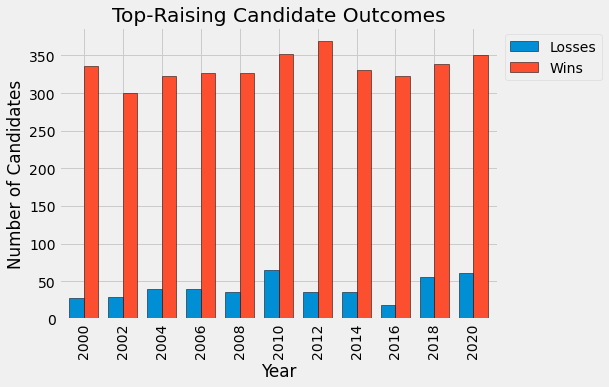

In [5]:
# Plot top-raising candidate outcomes
fig, ax = plt.subplots(figsize = (7, 5))

top_raisers_by_year.plot(kind = 'bar', edgecolor = 'black', width = 0.75, ax = ax)

ax.set_title('Top-Raising Candidate Outcomes')
ax.set_ylabel('Number of Candidates')
ax.legend(labels = ['Losses', 'Wins'], bbox_to_anchor = (1, 1))

plt.show()

&emsp;b\. How often does the candidate who spent more money win a race?  

In [6]:
# Filter elections with at least 2 candidates
contested_races = election_finances.groupby(['Year', 'State', 'District']).filter(lambda x: len(x) > 1)

# Keep candidate that spent most money
top_spenders = contested_races.sort_values('Spent', ascending = False).drop_duplicates(['Year', 'State', 'District'])

# Perform crosstab on year and winner columns
top_spenders_by_year = pd.crosstab(top_spenders['Year'], top_spenders['Winner'])

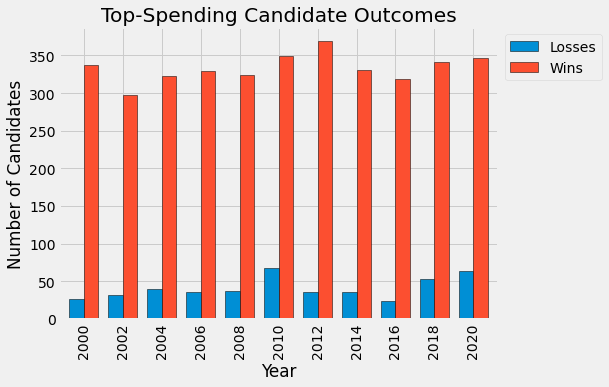

In [7]:
# Plot top-spending candidate outcomes
fig, ax = plt.subplots(figsize = (7, 5))

top_spenders_by_year.plot(kind = 'bar', edgecolor = 'black', width = 0.75, ax = ax)

ax.set_title('Top-Spending Candidate Outcomes')
ax.set_ylabel('Number of Candidates')
ax.legend(labels = ['Losses', 'Wins'], bbox_to_anchor = (1, 1))

plt.show()

&emsp;c\. Does the difference between either money raised or money spent seem to influence the likelihood of a candidate winning a race?  

In [8]:
# Filter elections with at least 2 candidates
contested_races = election_finances.groupby(['Year', 'State', 'District']).filter(lambda x: len(x) > 1)

# Keep election winner and runner-up that raised most money
total_raised = contested_races.sort_values('Raised', ascending = False).drop_duplicates(['Year', 'State', 'District', 'Winner'])

# Calculate difference in money raised
total_raised['Raised Difference'] = total_raised.sort_values('Raised').groupby(['Year', 'State', 'District'])['Raised'].diff()
total_raised = total_raised.dropna(subset = ['Raised Difference'])

# Convert booleans to ints
total_raised = total_raised.assign(Winner = total_raised['Winner'].astype(int))
total_raised = total_raised.assign(Incumbent = total_raised['Incumbent'].astype(int))

# Calculate relative log difference in money raised
total_raised['Raised Log Relative Difference'] = np.log10(total_raised['Raised'] / (total_raised['Raised'] - total_raised['Raised Difference']))
total_raised['Raised Log Relative Difference'] = total_raised['Raised Log Relative Difference'].replace(np.inf, np.nan)

/Users/rohitvenkat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# Subset 2020 election finance data
total_raised_2020 = total_raised[total_raised['Year'] == 2020]

# Build logistic model of win probability based on log relative difference in money raised
winner_raised_model = glm(formula = 'Winner ~ Q("Raised Log Relative Difference")', 
                          data = total_raised_2020,
                          family = sm.families.Binomial()
                         ).fit()

# Display model summary
display(winner_raised_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Winner   No. Observations:                  406
Model:                            GLM   Df Residuals:                      404
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -113.48
Date:                Fri, 22 Oct 2021   Deviance:                       226.97
Time:                        04:46:38   Pearson chi2:                     252.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -0.3102      0.255     -1.215      0.224      -0.811       0.190
Q("Raised Log Relative Difference")     4.2293      0.648      6.525      0.000       2.959       5.500
=======================================================================================================
"""

In [10]:
# Filter elections with at least 2 candidates
contested_races = election_finances.groupby(['Year', 'State', 'District']).filter(lambda x: len(x) > 1)

# Keep election winner and runner-up that spent most money
total_spent = contested_races.sort_values('Spent', ascending = False).drop_duplicates(['Year', 'State', 'District', 'Winner'])

# Calculate difference in money spent
total_spent['Spent Difference'] = total_spent.sort_values('Spent').groupby(['Year', 'State', 'District'])['Spent'].diff()
total_spent = total_spent.dropna(subset = ['Spent Difference'])

# Convert booleans to ints
total_spent = total_spent.assign(Winner = total_spent['Winner'].astype(int))
total_spent = total_spent.assign(Incumbent = total_spent['Incumbent'].astype(int))

# Calculate relative log difference in money spent
total_spent['Spent Log Relative Difference'] = np.log10(total_spent['Spent'] / (total_spent['Spent'] - total_spent['Spent Difference']))
total_spent['Spent Log Relative Difference'] = total_spent['Spent Log Relative Difference'].replace(np.inf, np.nan)

In [11]:
# Subset 2020 election finance data
total_spent_2020 = total_spent[total_spent['Year'] == 2020]

# Build logistic model of win probability based on log relative difference in money spent
winner_spent_model = glm(formula = 'Winner ~ Q("Spent Log Relative Difference")', 
                         data = total_spent_2020,
                         family = sm.families.Binomial()
                        ).fit()

# Display model summary
display(winner_spent_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Winner   No. Observations:                  403
Model:                            GLM   Df Residuals:                      401
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -120.01
Date:                Fri, 22 Oct 2021   Deviance:                       240.03
Time:                        04:46:39   Pearson chi2:                     282.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -0.2733      0.250     -1.093      0.275      -0.763       0.217
Q("Spent Log Relative Difference")     4.1825      0.654      6.391      0.000       2.900       5.465
======================================================================================================
"""

In [12]:
# Print model AIC values
print(winner_raised_model.aic)
print(winner_spent_model.aic)

230.96708467062695
244.0273494895796


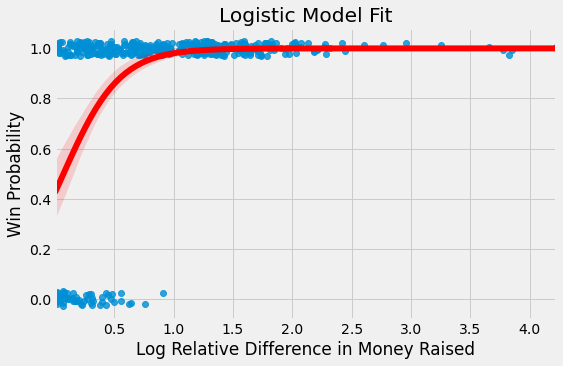

In [13]:
# Plot logistic model fit of win probability based on log relative difference in money raised
fig, ax = plt.subplots(figsize = (8, 5))

sns.regplot(x = 'Raised Log Relative Difference', 
            y = 'Winner', 
            data = total_raised_2020, 
            logistic = True, 
            line_kws={"color": "red"}, 
            y_jitter = 0.03, 
            ax = ax
)

ax.set_title('Logistic Model Fit')
ax.set_xlabel('Log Relative Difference in Money Raised')
ax.set_ylabel('Win Probability')

plt.show()

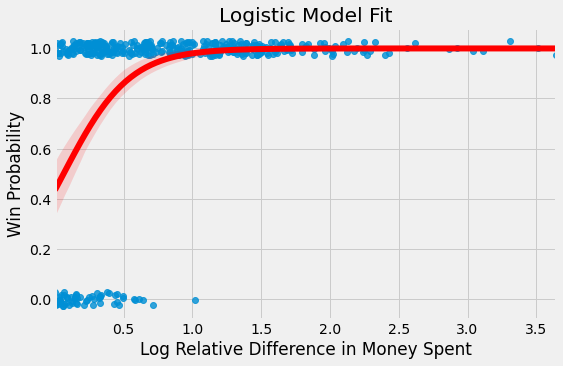

In [14]:
# Plot logistic model fit of win probability based on log relative difference in money spent
fig, ax = plt.subplots(figsize = (8, 5))

sns.regplot(x = 'Spent Log Relative Difference', 
            y = 'Winner', 
            data = total_spent_2020, 
            logistic = True, 
            line_kws={'color': 'red'}, 
            y_jitter = 0.03, 
            ax = ax
)

ax.set_title('Logistic Model Fit')
ax.set_xlabel('Log Relative Difference in Money Spent')
ax.set_ylabel('Win Probability')

plt.show()

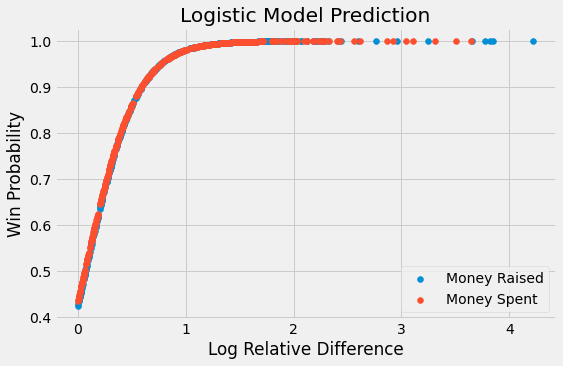

In [15]:
# Plot logistic model prediction of win probability based on log relative differences in money spent and raised
fig, ax = plt.subplots(figsize = (8, 5))

ax.scatter(total_raised_2020['Raised Log Relative Difference'].dropna(), winner_raised_model.predict())
ax.scatter(total_spent_2020['Spent Log Relative Difference'].dropna(), winner_spent_model.predict())

ax.set_title('Logistic Model Prediction')
ax.set_xlabel('Log Relative Difference')
ax.set_ylabel('Win Probability')
ax.legend(['Money Raised', 'Money Spent'])

plt.show()

&emsp;d\. How often does the incumbent candidate win a race?  

In [16]:
# Keep incumbent candidates
incumbents = election_finances[election_finances['Incumbent'] == True]

# Perform crosstab on year and winner columns
incumbent_winners_by_year = pd.crosstab(incumbents['Year'], incumbents['Winner'])

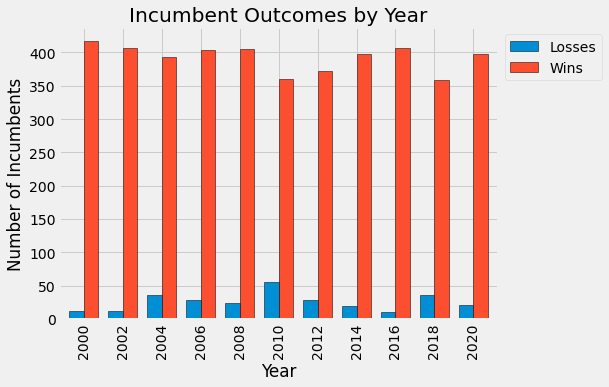

In [17]:
# Plot incumbent outcomes by year
fig, ax = plt.subplots(figsize = (7, 5))

incumbent_winners_by_year.plot(kind = 'bar', edgecolor = 'black', width = 0.75, ax = ax)

ax.set_title('Incumbent Outcomes by Year')
ax.set_ylabel('Number of Incumbents')
ax.legend(labels = ['Losses', 'Wins'], bbox_to_anchor = (1, 1))

plt.show()

&emsp;e\. Can you detect any relationship between amount of money raised and the incumbent status of a candidate?

In [18]:
# Subset 2020 election finance data
total_raised_2020 = total_raised[total_raised['Year'] == 2020]

# Build logistic model of incumbency probability based on log relative difference in money raised
incumbent_raised_model = glm(formula = 'Incumbent ~ Q("Raised Log Relative Difference")', 
                             data = total_raised_2020,
                             family = sm.families.Binomial()
                            ).fit()

# Display model summary
display(incumbent_raised_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Incumbent   No. Observations:                  406
Model:                            GLM   Df Residuals:                      404
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -189.97
Date:                Fri, 22 Oct 2021   Deviance:                       379.93
Time:                        04:46:46   Pearson chi2:                     413.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.2861      0.199      1.434      0.151      -0.105       0.677
Q("Raised Log Relative Difference")     1.3771      0.253      5.443      0.000       0.881       1.873
=======================================================================================================
"""

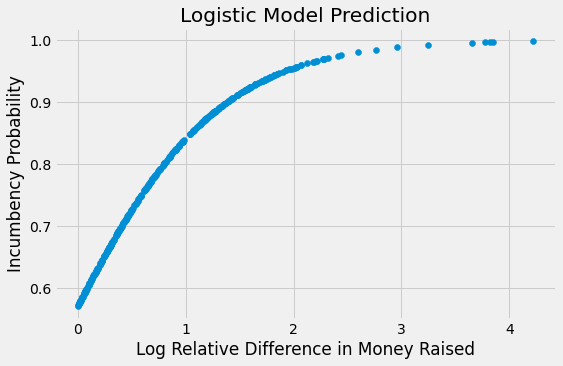

In [19]:
# Plot logistic model prediction of incumbency probability based on log relative difference in money raised
fig, ax = plt.subplots(figsize = (8, 5))

ax.scatter(total_raised_2020['Raised Log Relative Difference'].dropna(), incumbent_raised_model.predict())

ax.set_title('Logistic Model Prediction')
ax.set_xlabel('Log Relative Difference in Money Raised')
ax.set_ylabel('Incumbency Probability')

plt.show()

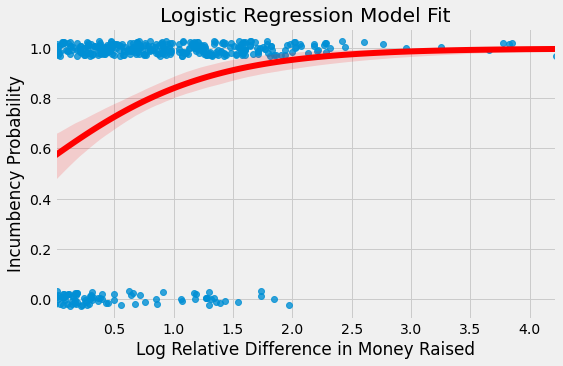

In [20]:
# Plot logistic model fit of incumbency probability based on log relative difference in money raised
fig, ax = plt.subplots(figsize = (8, 5))

sns.regplot(x = 'Raised Log Relative Difference', 
            y = 'Incumbent', 
            data = total_raised_2020, 
            logistic = True, 
            line_kws={'color': 'red'}, 
            y_jitter = 0.03, 
            ax = ax
)

ax.set_title('Logistic Regression Model Fit')
ax.set_xlabel('Log Relative Difference in Money Raised')
ax.set_ylabel('Incumbency Probability')

plt.show()

### Bonus Questions:
If you complete all of the above, you can attempt these challenging bonus questions.

Open Secrets also gives a detailed breakdown of contributions by source. For example, for Tennessee's second district, this is located at https://www.opensecrets.org/races/candidates?cycle=2020&id=TN02&spec=N

Scrape these pages to get information on contributions by source. See if you can find anything interesting in terms of the source of contributions. Some examples to get you started:
* What does the overall distribution of funding sources look like?
* Is there any detectable difference in contribution sources between Democrat and Republican candidates?
* Do the funding sources for either the winning candidate or incumbent candidate differ from the other candidates?

In [21]:
# Subset election finance data from 2010 to 2020
election_finances_2010_to_2020 = election_finances[election_finances['Year'] >= 2010]

# Funding source columns
funding_sources = ['Small Individual Contributions',
                   'Large Individual Contributions',
                   'PAC Contributions',
                   'Candidate self-financing',
                   'Other']

# Filter candidates that are democrat or republican
election_finances_D_or_R = election_finances_2010_to_2020[election_finances_2010_to_2020['Party'].isin(['D','R'])]

# Aggregate funding sources by party
funding_sources_by_party = election_finances_D_or_R.groupby('Party')[funding_sources].agg('sum')

# Calculate funding source percentages
funding_sources_by_party = (funding_sources_by_party.T / funding_sources_by_party.sum(axis = 1)).T

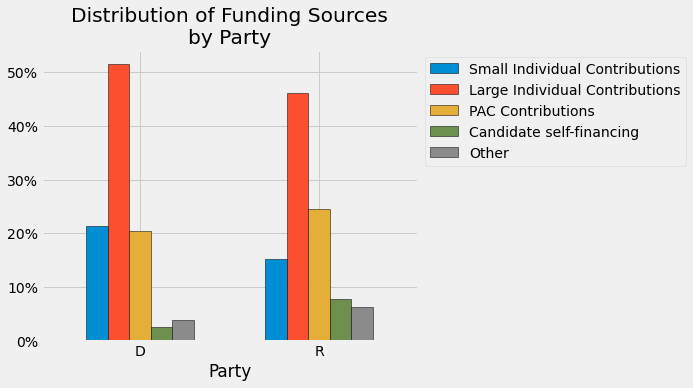

In [22]:
# Plot distribution of funding sources by party
fig, ax = plt.subplots(figsize = (6, 5))

funding_sources_by_party.plot(kind = 'bar', edgecolor = 'black', width = 0.6, ax = ax)

ax.set_title('Distribution of Funding Sources\nby Party')
ax.tick_params(axis = 'x', labelrotation = 0)
formatter = FuncFormatter(lambda y, pos: '%d%%' % (y * 100))
ax.yaxis.set_major_formatter(formatter)
ax.legend(bbox_to_anchor = (1, 1))

plt.show()

In [23]:
# Subset election finance data from 2010 to 2020
election_finances_2010_to_2020 = election_finances[election_finances['Year'] >= 2010]

# Funding source columns
funding_sources = ['Small Individual Contributions',
                   'Large Individual Contributions',
                   'PAC Contributions',
                   'Candidate self-financing',
                   'Other']

# Aggregate funding sources by election outcome
funding_sources_by_winner = election_finances_2010_to_2020.groupby('Winner')[funding_sources].agg('sum')

# Calculate funding source percentages
funding_sources_by_winner = (funding_sources_by_winner.T / funding_sources_by_winner.sum(axis = 1)).T

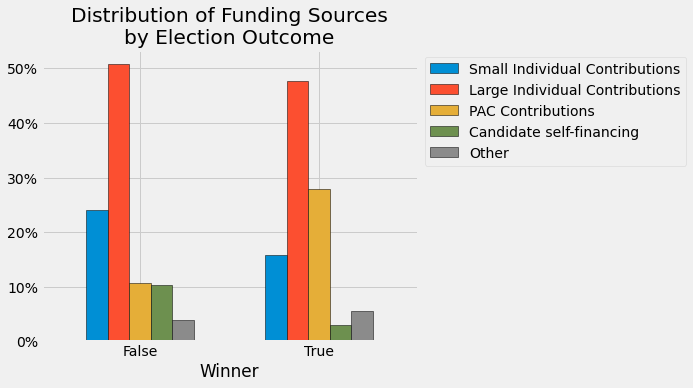

In [24]:
# Plot distribution of funding sources by election outcome
fig, ax = plt.subplots(figsize = (6, 5))

funding_sources_by_winner.plot(kind = 'bar', edgecolor = 'black', width = 0.6, ax = ax)

ax.set_title('Distribution of Funding Sources\nby Election Outcome')
ax.tick_params(axis = 'x', labelrotation = 0)
formatter = FuncFormatter(lambda y, pos: '%d%%' % (y * 100))
ax.yaxis.set_major_formatter(formatter)
ax.legend(bbox_to_anchor = (1, 1))

plt.show()

In [25]:
# Subset election finance data from 2010 to 2020
election_finances_2010_to_2020 = election_finances[election_finances['Year'] >= 2010]

# Funding source columns
funding_sources = ['Small Individual Contributions',
                   'Large Individual Contributions',
                   'PAC Contributions',
                   'Candidate self-financing',
                   'Other']

# Aggregate funding sources by incumbent status
funding_sources_by_incumbent = election_finances_2010_to_2020.groupby('Incumbent')[funding_sources].agg('sum')

# Calculate funding source percentages
funding_sources_by_incumbent = (funding_sources_by_incumbent.T / funding_sources_by_incumbent.sum(axis = 1)).T

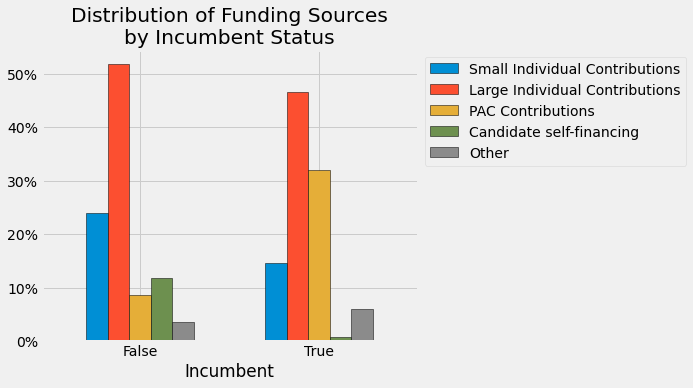

In [26]:
# Plot distribution of funding sources by incumbent status
fig, ax = plt.subplots(figsize = (6, 5))

funding_sources_by_incumbent.plot(kind = 'bar', edgecolor = 'black', width = 0.6, ax = ax)

ax.set_title('Distribution of Funding Sources\nby Incumbent Status')
ax.tick_params(axis = 'x', labelrotation = 0)
formatter = FuncFormatter(lambda y, pos: '%d%%' % (y * 100))
ax.yaxis.set_major_formatter(formatter)
ax.legend(bbox_to_anchor = (1, 1))

plt.show()

In [27]:
# Create new column to differentiate between senate and house elections
election_finances['Election Type'] = election_finances['District'].map(lambda x: 'Senate' if x in ['S1', 'S2'] else 'House')

# Subset election finance data from 2010 to 2020
election_finances_2010_to_2020 = election_finances[election_finances['Year'] >= 2010]

# Funding source columns
funding_sources = ['Small Individual Contributions',
                   'Large Individual Contributions',
                   'PAC Contributions',
                   'Candidate self-financing',
                   'Other']

# Aggregate funding sources by election type
funding_sources_by_election_type = election_finances_2010_to_2020.groupby('Election Type')[funding_sources].agg('sum')

# Calculate funding source percentages
funding_sources_by_election_type = (funding_sources_by_election_type.T / funding_sources_by_election_type.sum(axis = 1)).T

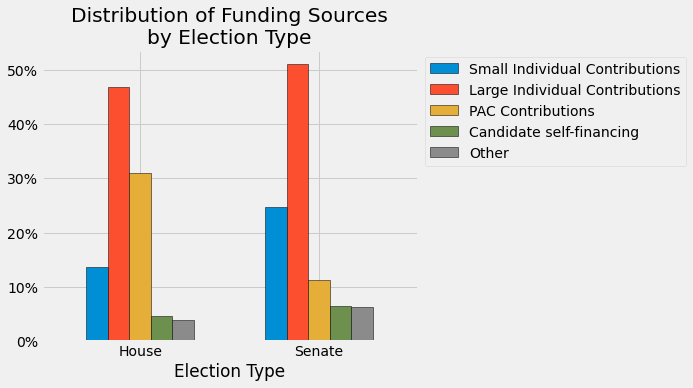

In [28]:
# Plot distribution of funding sources by election type
fig, ax = plt.subplots(figsize = (6, 5))

funding_sources_by_election_type.plot(kind = 'bar', edgecolor = 'black', width = 0.6, ax = ax)

ax.set_title('Distribution of Funding Sources\nby Election Type')
ax.tick_params(axis = 'x', labelrotation = 0)
formatter = FuncFormatter(lambda y, pos: '%d%%' % (y * 100))
ax.yaxis.set_major_formatter(formatter)
ax.legend(bbox_to_anchor = (1, 1))

plt.show()

In [29]:
# Create new column to differentiate between senate and house elections
election_finances['Election Type'] = election_finances['District'].map(lambda x: 'Senate' if x in ['S1', 'S2'] else 'House')

# Subset election finance data from 2010 to 2020
election_finances_2010_to_2020 = election_finances[election_finances['Year'] >= 2010]

# Funding source columns
funding_sources = ['Small Individual Contributions',
                   'Large Individual Contributions',
                   'PAC Contributions',
                   'Candidate self-financing',
                   'Other']

# Aggregate funding sources by election type and incumbent status
funding_sources_by_election_type_incumbent = election_finances_2010_to_2020.groupby(['Election Type', 'Incumbent'])[funding_sources].agg('sum')

# Calculate funding source percentages
funding_sources_by_election_type_incumbent = (funding_sources_by_election_type_incumbent.T / funding_sources_by_election_type_incumbent.sum(axis = 1)).T

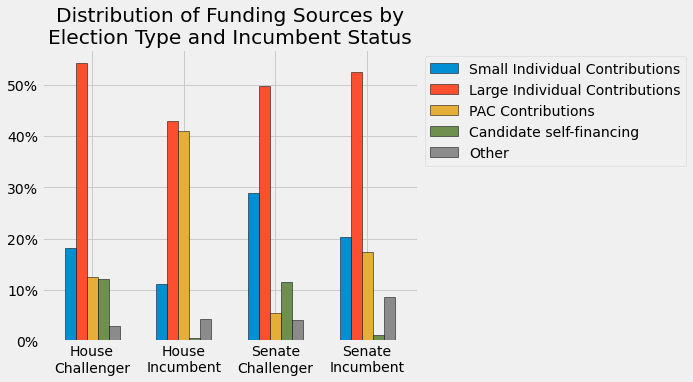

In [30]:
# Plot distribution of funding sources by election type and incumbent status
fig, ax = plt.subplots(figsize = (6, 5))

funding_sources_by_election_type_incumbent.plot(kind = 'bar', edgecolor = 'black', width = 0.6, ax = ax)

ax.tick_params(axis = 'x', labelrotation = 0)
ax.set_xticklabels(['House\nChallenger', 'House\nIncumbent', 'Senate\nChallenger', 'Senate\nIncumbent'])
ax.set_xlabel('')
ax.set_title('Distribution of Funding Sources by\nElection Type and Incumbent Status')
formatter = FuncFormatter(lambda y, pos: '%d%%' % (y * 100))
ax.yaxis.set_major_formatter(formatter)
ax.legend(bbox_to_anchor = (1, 1))

plt.show()

In [31]:
# Columns to aggregate 
agg_columns = {'Name': 'count',
			   'Incumbent': 'sum',
			   'Winner': 'sum',
			   'Raised': 'sum',
			   'Spent': 'sum',
			   'Individual Contributions': 'sum',
			   'Small Individual Contributions': 'sum',
			   'Large Individual Contributions': 'sum',
			   'PAC Contributions': 'sum',
			   'Candidate self-financing': 'sum',
			   'Other': 'sum',
			   'Full Disclosure': 'sum',
			   'Incomplete Disclosure': 'sum',
			   'No Disclosure': 'sum'
}

# Aggregate all election finance data by year
totals_by_year = election_finances.groupby('Year', as_index = False).agg(agg_columns)

# Add small and large individual contributions to individual contributions column
totals_by_year['Individual Contributions'] += totals_by_year[['Small Individual Contributions', 'Large Individual Contributions']].sum(axis = 1)

In [32]:
# Funding source columns
funding_sources = ['Small Individual Contributions',
                   'Large Individual Contributions',
                   'PAC Contributions',
                   'Candidate self-financing',
                   'Other']

# Subset funding source totals from 2010 to 2020
funding_sources_2010_to_2020 = totals_by_year[totals_by_year['Year'] >= 2010].set_index('Year')[funding_sources]

# Calculate funding source percentages
funding_sources_2010_to_2020 = (funding_sources_2010_to_2020.T / funding_sources_2010_to_2020.sum(axis = 1)).T

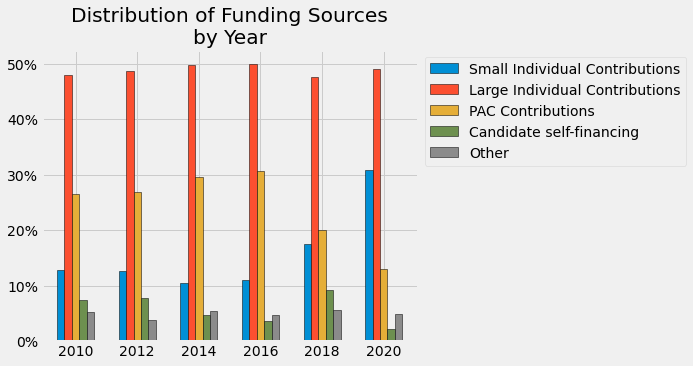

In [33]:
# Plot distribution of funding sources by year
fig, ax = plt.subplots(figsize = (6, 5))

funding_sources_2010_to_2020.plot(kind = 'bar', edgecolor = 'black', width = 0.6, ax = ax)

ax.tick_params(axis = 'x', labelrotation = 0)
ax.set_xlabel('')
ax.set_title('Distribution of Funding Sources\nby Year')
formatter = FuncFormatter(lambda y, pos: '%d%%' % (y * 100))
ax.yaxis.set_major_formatter(formatter)
ax.legend(bbox_to_anchor = (1, 1))

plt.show()

In [34]:
# Funding source columns
funding_sources = ['Individual Contributions',
                   'PAC Contributions',
                   'Candidate self-financing',
                   'Other']

# Subset funding source totals from 2000 to 2020
funding_sources_2000_to_2020 = totals_by_year.set_index('Year')[funding_sources]

# Calculate funding source percentages
funding_sources_2000_to_2020 = (funding_sources_2000_to_2020.T / funding_sources_2000_to_2020.sum(axis = 1)).T

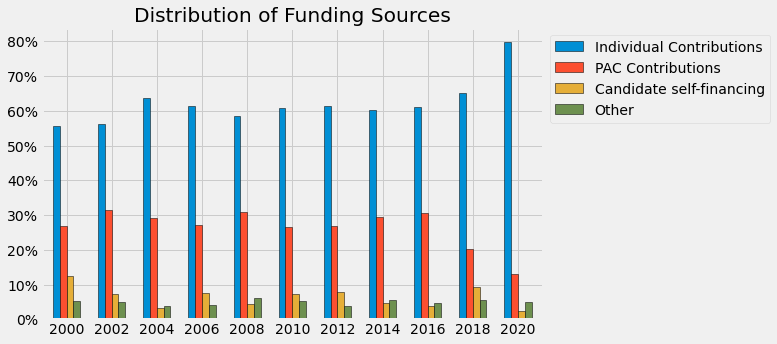

In [35]:
# Plot distribution of funding sources by year
fig, ax = plt.subplots(figsize = (8, 5))

funding_sources_2000_to_2020.plot(kind = 'bar', edgecolor = 'black', width = 0.6, ax = ax)

ax.tick_params(axis = 'x', labelrotation = 0)
ax.set_xlabel('')
ax.set_title('Distribution of Funding Sources')
formatter = FuncFormatter(lambda y, pos: '%d%%' % (y * 100))
ax.yaxis.set_major_formatter(formatter)
ax.legend(bbox_to_anchor = (1, 1))

plt.show()

In [36]:
# Columns to aggregate
agg_columns = {'Name': 'count',
			   'Incumbent': 'sum',
			   'Winner': 'sum',
			   'Raised': 'sum',
			   'Spent': 'sum',
			   'Individual Contributions': 'sum',
			   'Small Individual Contributions': 'sum',
			   'Large Individual Contributions': 'sum',
			   'PAC Contributions': 'sum',
			   'Candidate self-financing': 'sum',
			   'Other': 'sum',
			   'Full Disclosure': 'sum',
			   'Incomplete Disclosure': 'sum',
			   'No Disclosure': 'sum'
}

# Aggregate all election finance data by year and party
totals_by_year_and_party = election_finances.groupby(['Year', 'Party'], as_index = False).agg(agg_columns)
totals_by_year_and_party = totals_by_year_and_party[totals_by_year_and_party['Party'].isin(['D', 'R'])]

In [37]:
# Funding source columns
funding_sources = ['Small Individual Contributions',
                   'Large Individual Contributions',
                   'PAC Contributions',
                   'Candidate self-financing',
                   'Other']

# Subset funding source totals from 2010 to 2020
funding_sources_by_party_2010_to_2020 = totals_by_year_and_party[totals_by_year_and_party['Year'] >= 2010].set_index(['Year', 'Party'])[funding_sources]

# Calculate funding source percentages
funding_sources_by_party_2010_to_2020 = (funding_sources_by_party_2010_to_2020.T / funding_sources_by_party_2010_to_2020.sum(axis = 1)).T

# Subset funding source data for democratic candidates
democrat_funding_sources_2010_to_2020 = funding_sources_by_party_2010_to_2020.query('Party == "D"').droplevel(1)

# Subset funding source data for republican candidates
republican_funding_sources_2010_to_2020 = funding_sources_by_party_2010_to_2020.query('Party == "R"').droplevel(1)

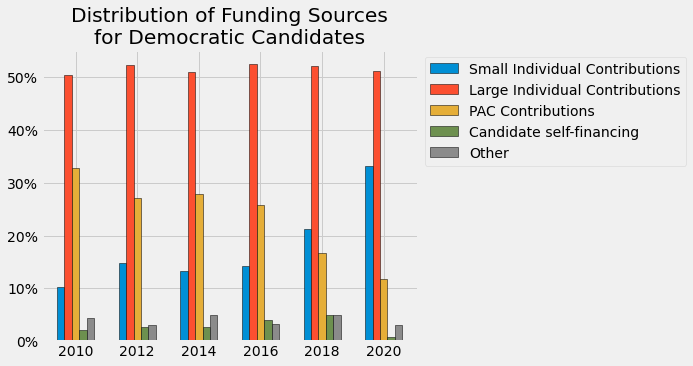

In [38]:
# Plot distribution of funding sources for democratic candidates
fig, ax = plt.subplots(figsize = (6, 5))

democrat_funding_sources_2010_to_2020.plot(kind = 'bar', edgecolor = 'black', width = 0.6, ax = ax)

ax.tick_params(axis = 'x', labelrotation = 0)
ax.set_xlabel('')
ax.set_title('Distribution of Funding Sources\nfor Democratic Candidates')
formatter = FuncFormatter(lambda y, pos: '%d%%' % (y * 100))
ax.yaxis.set_major_formatter(formatter)
ax.legend(bbox_to_anchor = (1, 1))

plt.show()

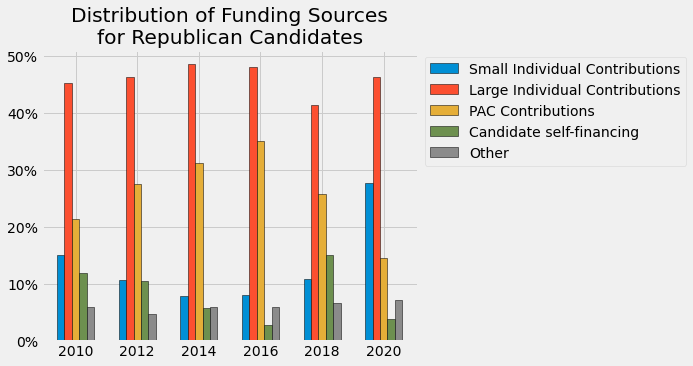

In [39]:
# Plot distribution of funding sources for republican candidates
fig, ax = plt.subplots(figsize = (6, 5))

republican_funding_sources_2010_to_2020.plot(kind = 'bar', edgecolor = 'black', width = 0.6, ax = ax)

ax.tick_params(axis = 'x', labelrotation = 0)
ax.set_xlabel('')
ax.set_title('Distribution of Funding Sources\nfor Republican Candidates')
formatter = FuncFormatter(lambda y, pos: '%d%%' % (y * 100))
ax.yaxis.set_major_formatter(formatter)
ax.legend(bbox_to_anchor = (1, 1))

plt.show()